# Sales data analysis

The goal of this project is to perform analysis on the given sales data in order to answer the following five questions:

1. What was the best month for sales and how much money was earned that month?
2. What city had the highest amount of sales?
3. What time should we display advertisements in order to maximize the likelihood of the customer buying the product?
4. What products are most often sold together?
5. What products are sold the most and why?

The data has been given in the form of 12 csv files, each containing a month of data.

### Importing the necessary libraries:

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from itertools import combinations
from collections import Counter

plt.style.use('ggplot')

## Phase 1: Data preparation:

### Merging the 12 monthly sales data files into a single file:

In [35]:
df = pd.read_csv("./Sales_Data/Sales_April_2019.csv")
# df.head()

year_data = pd.DataFrame()


files = [file for file in os.listdir('./Sales_Data')]

for file in files:
    df = pd.read_csv("./Sales_Data/" + file)
    year_data = pd.concat([year_data, df])

year_data.to_csv("all-data.csv", index = False)

# year_data.head()

In [36]:
# Reading in, the updated dataframe, so we don't have to run the entire block above to get that file.
all_data = pd.read_csv("./all-data.csv")
# all_data.head()

### Cleaning the data:

First, we must have a look at the NaN values, and see how they are structured throughout the data, which would lead us to figuring out what is the best way to deal with them.

In [92]:
# nandf = all_data[all_data.isna().any(axis = 1)]
# nandf.head()

Since the NaN values are whole rows, we can just remove them by using dropna(). However, we shall convert the dtypes of the required columns first, while putting in the "errors = 'coerce'" argument, in order to convert those non-numerical values which are in numerical value columns into NaN values, in order for us to deal with them more easily.

In [179]:
convert_dict = {
    'Order ID'         : 'int',
    'Quantity Ordered' : 'int',
    'Price Each'       : 'float',
    'Order Date'       : 'datetime64[ns]'
}

for col, new_dtype in convert_dict.items():
    
    if new_dtype == 'float':
        all_data[col] = pd.to_numeric(all_data[col], errors = 'coerce')
    
    elif new_dtype == 'int':
        all_data[col] = pd.to_numeric(all_data[col], downcast = "integer", errors = 'coerce')
    
    elif new_dtype == 'datetime64[ns]':
        all_data[col] = pd.to_datetime(all_data[col],errors = 'coerce')
    
    else:
        all_data[col] = all_data[col].astype(str)
    
all_data.dtypes

Order ID                     int32
Product                     object
Quantity Ordered              int8
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
Month                        int32
Total Price                float64
Hour                         int32
City                        object
Months                       int32
dtype: object

In [89]:
all_data = all_data.dropna(how = 'all')
all_data = all_data[all_data['Product'].str[0:7] !="Product"]

nandf = all_data[all_data.isna().any(axis = 1)]
# nandf.shape
nandf.head(355)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


### Augmenting additionally required columns

Taking a look at the questions asked, we can see that we are going to need the following additional columns for our analysis:
* Total Price (price each $*$ quantity ordered)
* Month
* City
* Hour

In [108]:
all_data['Months'] = all_data['Order Date'].dt.month
all_data['Months'] = pd.to_numeric(all_data['Months'])
all_data['Total Price'] = all_data['Quantity Ordered'] * all_data['Price Each']
all_data['Hour'] = all_data['Order Date'].dt.hour

def get_city(address):
    return address.split(',')[1]

def get_state(address):
    return address.split(',')[2].split(' ')[1]


all_data['City'] = all_data['Purchase Address'].apply( lambda x: get_city(x) + " (" + get_state(x) + ")" )

# all_data.head()

## Phase 2: Answering the questions:

#### $1.$ What was the best month for sales and how much money was earned that month?

Months
1     1822256.73
2     2202022.42
3     2807100.38
4     3390670.24
5     3152606.75
6     2577802.26
7     2647775.76
8     2244467.88
9     2097560.13
10    3736726.88
11    3199603.20
12    4613443.34
Name: Total Price, dtype: float64




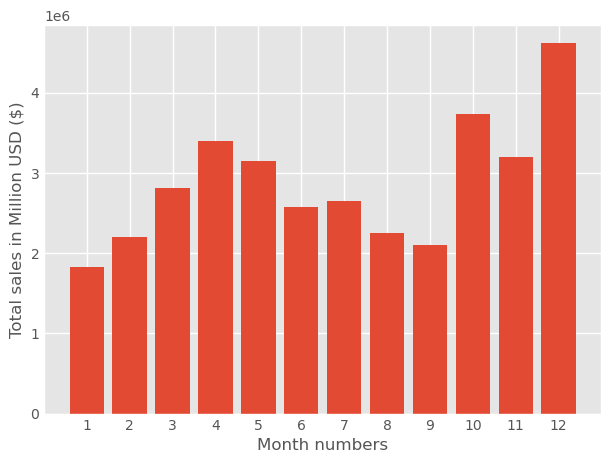

In [175]:
results_q1 = all_data.groupby(all_data['Months']).sum(['Total Price'])
print(results_q1['Total Price'])
print("\n")

months = [month for month,df in all_data.groupby('Months')]
# months

plt.bar(months, results_q1['Total Price'])
plt.xticks(months)
plt.xlabel("Month numbers")
plt.ylabel("Total sales in Million USD ($)")

plt.show()

So, the month of December had the best sales, i.e. $4,613,443.34$ USD.

#### $2.$ What city had the highest amount of sales?

City
 Atlanta (GA)          2795498.58
 Austin (TX)           1819581.75
 Boston (MA)           3661642.01
 Dallas (TX)           2767975.40
 Los Angeles (CA)      5452570.80
 New York City (NY)    4664317.43
 Portland (ME)          449758.27
 Portland (OR)         1870732.34
 San Francisco (CA)    8262203.91
 Seattle (WA)          2747755.48
Name: Total Price, dtype: float64




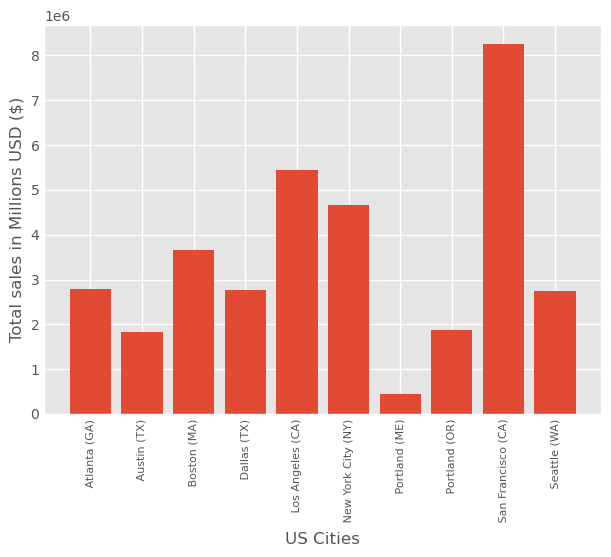

In [176]:
result_q2 = all_data.groupby(all_data['City']).sum(['Total Price'])
print(result_q2["Total Price"])
print("\n")
cities = [city for city,df in all_data.groupby('City')]

plt.bar(cities,result_q2["Total Price"])
plt.xticks(cities, rotation = 'vertical', size = 8)
plt.xlabel("US Cities")
plt.ylabel("Total sales in Millions USD ($)")
plt.show()

The highest amount of sales were observed in San Francisco, which amounted to a total of $8,262,203.91$ USD

#### $3.$ What time should we display advertisements in order to maximize the likelihood of the customer buying the product?

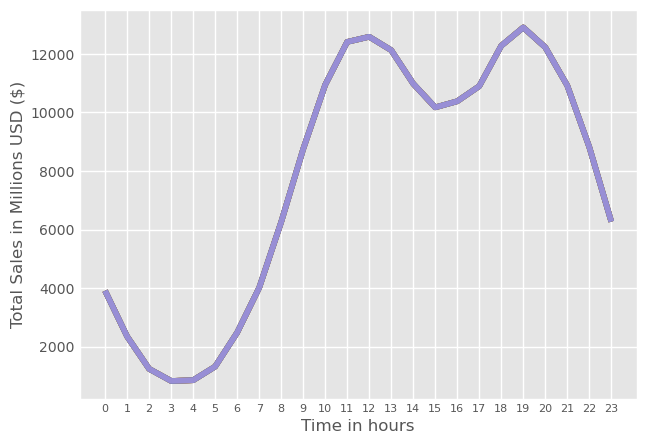

In [177]:
result_q3 = all_data.groupby(all_data['Hour']).sum(['Total Price'])

hours = [hour for hour,df in all_data.groupby('Hour')]

plt.plot(hours,all_data.groupby('Hour').count())
plt.xticks(hours, size = 8)
# plt.grid()
plt.xlabel("Time in hours")
plt.ylabel("Total Sales in Millions USD ($)")

plt.show()

As we can see, the highest amount of sales arise between 11:00 - 13:00 hours and between 18:00 - 20:00 hours, which is when an advertisement displayed can help improve the sales further, and most effectively. Additionally, the peak at 19:00 hours is visibly sharper, corresponging to a sudden spike in sales, which is a great opportunity to increase it even further by displaying advertisements.

#### $4.$ What products are most often sold together?

In [199]:
df = all_data[all_data['Order ID'].duplicated(keep = False)]

df['Grouped Products'] = df.groupby('Order ID')['Product'].transform(lambda x: ', '.join(x))

df = df[['Order ID','Grouped Products']].drop_duplicates()
# df.head()

/tmp/ipykernel_684287/1554986527.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
count = Counter()

for row in df['Grouped Products']:
    row_list = row.split(', ')
    count.update(Counter(combinations(row_list,2)))
    
for key, value in count.most_common(10):
    print(key,value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


In [204]:
count = Counter()

for row in df['Grouped Products']:
    row_list = row.split(', ')
    count.update(Counter(combinations(row_list,3)))
    
for key, value in count.most_common(5):
    print(key, value)

('Google Phone', 'USB-C Charging Cable', 'Wired Headphones') 87
('iPhone', 'Lightning Charging Cable', 'Wired Headphones') 62
('iPhone', 'Lightning Charging Cable', 'Apple Airpods Headphones') 47
('Google Phone', 'USB-C Charging Cable', 'Bose SoundSport Headphones') 35
('Vareebadd Phone', 'USB-C Charging Cable', 'Wired Headphones') 33


Given above are the most common pairs and triplets of items sold together.

#### $5.$ What products are sold the most and why?

In [262]:
products_grouped = all_data.groupby('Product')
result_q5 = all_data.groupby('Product').sum(['Quantity Ordered'])

prices = all_data.groupby('Product').mean(['Price Each'])

products = [product for product, df in products_grouped]
# products
# result_q5
# prices

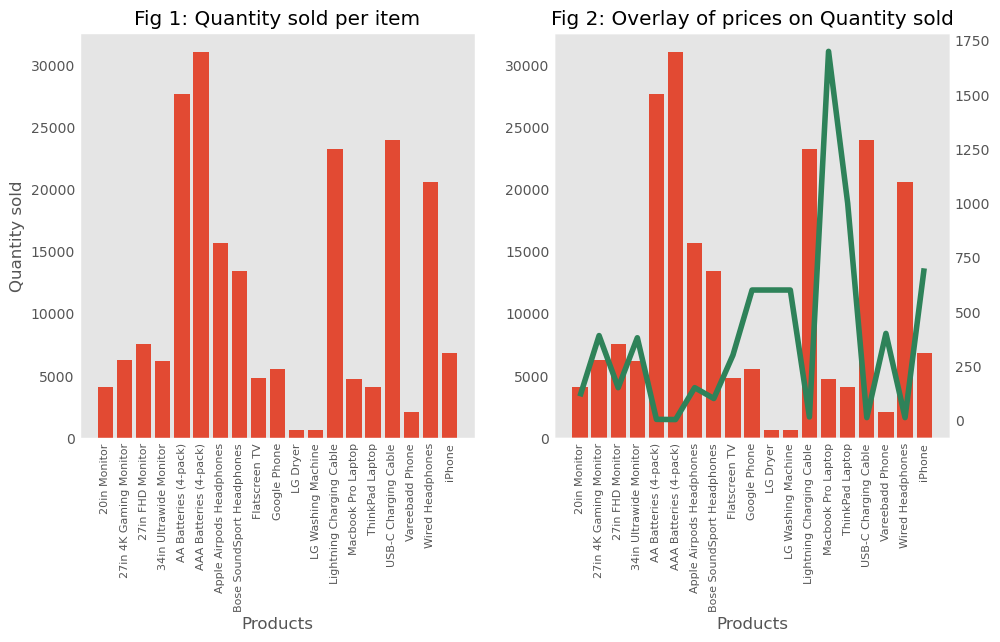

In [267]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

ax1[0].bar(products,result_q5['Quantity Ordered'])
ax1[0].set_title('Fig 1: Quantity sold per item')
ax1[0].set_xticks(products)
ax1[0].set_xticklabels(products, rotation = 'vertical', size = 8)
ax1[0].set_xlabel("Products")
ax1[0].set_ylabel("Quantity sold")
ax1[0].grid(False)

ax2 = ax1[1].twinx()

ax1[1].bar(products,result_q5['Quantity Ordered'], zorder = 2)
ax1[1].set_title('Fig 2: Overlay of prices on Quantity sold')
ax1[1].grid(False)
ax1[1].set_xticks(products)
ax1[1].set_xticklabels(products, rotation = 'vertical', size = 8)
ax1[1].set_xlabel("Products")

ax2.plot(products,prices['Price Each'],zorder = 1, color = '#2E8259')
ax2.grid(False)




# plt.tight_layout()
plt.show()


As observed from fig.1, AA and AAA batteries are the most frequently sold item in the store. It is hypothesised that this is caused due to the low prices of these items, and as justification, an overlayed graph of price per unit(fig.2) has been shown, that depicts the correlation between the two.

Google Phone and especially iphone defy these trends, which might be because of their high demand.